## 목적
- training 기간이 달라질 경우 성능의 차이가 있을까?
- 물론 이전 05-1.different_test_period에서 봤을 때, 기간이 멀지 않을수록 성능이 좋다는 걸 알 수 있었음
- 그러면 실제 테스트 셋을 고정시키고 가까운 달의 데이터로 학습해서 보자

## 설계 - 2가지 방법
1.  train 기간 고정, test 기간 변경
    - train: input(1월), label(2월)
    - test: input(2,3,4,5), label(3,4,5,6)
2.  train 기간 변경, test 기간 고정
    - train: input(1,2,3,4), label(2,3,4,5)
    - test: input(5), label(6)

- split: 8:2
- sampling: 20%
- model: lightgbm
- evaluation: auprc

## 이 페이지 에서는 2번 실험을 다룬다
- different train period

## package

In [3]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sm_utils import sampling, evaluate, show_results, save_model, load_model, make_train_data,  make_test_data

/home/dmig/py_libs/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
DATA_PATH = '/home/dmig/work/upsell/data/'
RESULT_PATH = '/home/dmig/work/upsell/result/training_preriod/'

In [4]:
def test_different_period(clf, test_ym):
    print('test ym: ', test_ym)
    
    # load data
    print('load data')
    df_mart = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_{}.pkl'.format(test_ym)))
    print('df_mart: ', df_mart.shape)
    
    # make test data format
    print('make test data format')
    result = make_test_data(df_mart)
    idx = result['idx']
    x_test = result['x']
    y_test = result['y']
    feature_cols = list(x_test.columns)
    print('x_test: ', x_test.shape)
    print('y_test: ', y_test.shape)
    
    # evaluation
    print('evaluation')
    t1 = time.time()
    lgb_result_dict = evaluate(x_test, y_test.label.values, clf, 'lgb')
    print('elapsed time: ', time.time()-t1)

### 4월 데이터로 학습

In [4]:
# load data
df_mart04 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201904.pkl'))
df_mart04.shape

(18626176, 81)

In [6]:
# make train data
result = make_train_data(df_mart04)
result.keys()

make_train_data +++
label/sample:  0.2
sample/total:  0.13686330463107405
make_data_for_modeling---


dict_keys(['trn', 'val'])

In [7]:
trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']


val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

trn_idx.shape, x_trn.shape, y_trn.shape, val_idx.shape, x_val.shape, y_val.shape

((2447270, 1),
 (2447270, 79),
 (2447270, 1),
 (611818, 1),
 (611818, 79),
 (611818, 1))

In [10]:
feature_cols = list(x_trn.columns)

In [11]:
# parameter
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 512,
    'lambda_l1': 3,
    'lambda_l2': 1,
    'learning_rate': 0.05,
    'num_threads': 30,
}

In [12]:
lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

In [13]:
# modeling
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=2000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.904305	valid_1's auc: 0.900358
[100]	training's auc: 0.935482	valid_1's auc: 0.930997
[150]	training's auc: 0.946527	valid_1's auc: 0.94078
[200]	training's auc: 0.953659	valid_1's auc: 0.946548
[250]	training's auc: 0.958972	valid_1's auc: 0.95052
[300]	training's auc: 0.96319	valid_1's auc: 0.953256
[350]	training's auc: 0.965918	valid_1's auc: 0.954351
[400]	training's auc: 0.968106	valid_1's auc: 0.954912
[450]	training's auc: 0.969995	valid_1's auc: 0.955127
[500]	training's auc: 0.972293	valid_1's auc: 0.956326
[550]	training's auc: 0.973874	valid_1's auc: 0.95651
[600]	training's auc: 0.975394	valid_1's auc: 0.956935
[650]	training's auc: 0.976877	valid_1's auc: 0.957321
[700]	training's auc: 0.978174	valid_1's auc: 0.957608
[750]	training's auc: 0.979379	valid_1's auc: 0.95794
[800]	training's auc: 0.980494	valid_1's auc: 0.958155
[850]	training's auc: 0.981578	valid_1's auc: 0.958427
[900]	tr

In [14]:
## save model
save_model(clf, os.path.join(RESULT_PATH, 'model_201904.pkl'))

save model to  /home/dmig/work/upsell/result/training_preriod/model_201904.pkl


## 5월 데이터로 test

test ym:  201905
load data
df_mart:  (18707537, 81)
make test data format
x_test:  (18707537, 79)
y_test:  (18707537, 1)
evaluation
        acc    recall  precision  f1_score       auc
0  0.668474  0.590905   0.041016  0.076707  0.687622
         pred: 1   pred: 0
true: 1   257633    178364
true: 0  6023666  12247874
                       feature   description  importance
44     avg_subscription_period  평균 요금제 변경 주기       81513
5              svc_scrb_period           NaN       78833
6            last_equip_period           NaN       64242
49               real_avg_arpu       평균 ARPU       61711
46             real_arpu_bf_m1       순수 ARPU       45807
48             real_arpu_bf_m3       순수 ARPU       45745
1                          age            나이       42957
47             real_arpu_bf_m2       순수 ARPU       39660
3              mng_nice_cb_scr     나이스 신용 점수       37908
53            data_usage_ratio           NaN       34808
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율       324

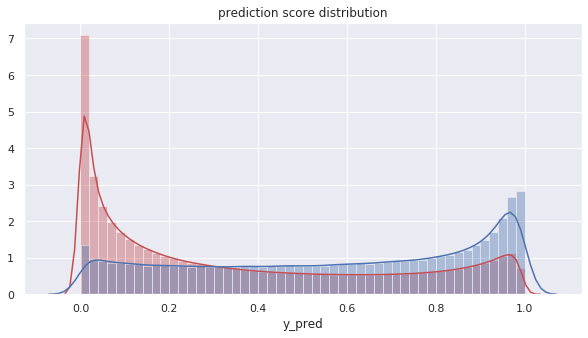

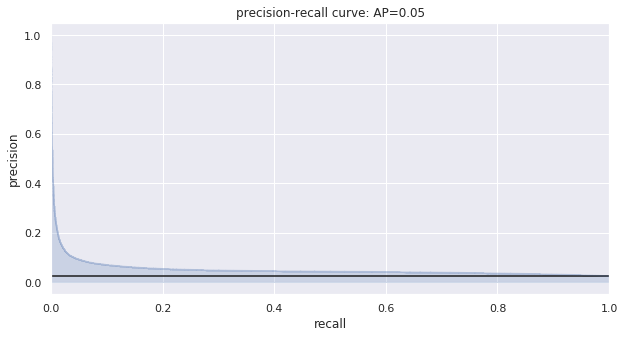

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/lgb_0707_090021.pkl
save model to  /home/dmig/work/upsell/result/lgb_0707_090021.pkl
elapsed time:  492.2886667251587


In [16]:
test_different_period(clf, '201905')

#### 엄청 안좋음.....

## 3월 데이터로 테스트

test ym:  201903
load data
df_mart:  (18580984, 81)
make test data format
x_test:  (18580984, 79)
y_test:  (18580984, 1)
evaluation
        acc    recall  precision  f1_score       auc
0  0.894203  0.873587   0.174184  0.290454  0.952727
         pred: 1   pred: 0
true: 1   402353     58223
true: 0  1907584  16212824
                       feature   description  importance
44     avg_subscription_period  평균 요금제 변경 주기       81513
5              svc_scrb_period           NaN       78833
6            last_equip_period           NaN       64242
49               real_avg_arpu       평균 ARPU       61711
46             real_arpu_bf_m1       순수 ARPU       45807
48             real_arpu_bf_m3       순수 ARPU       45745
1                          age            나이       42957
47             real_arpu_bf_m2       순수 ARPU       39660
3              mng_nice_cb_scr     나이스 신용 점수       37908
53            data_usage_ratio           NaN       34808
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율       324

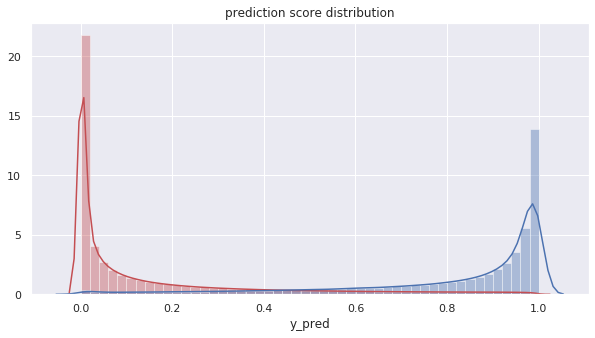

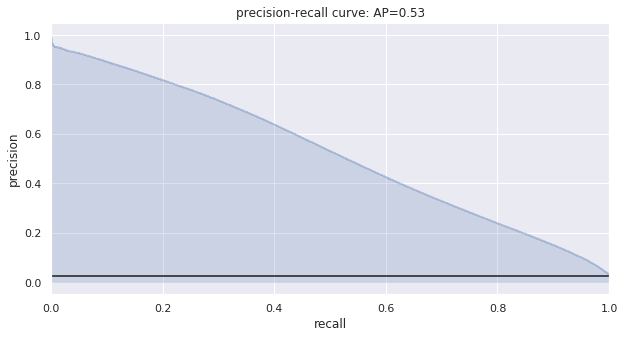

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/lgb_0708_111724.pkl
save model to  /home/dmig/work/upsell/result/lgb_0708_111724.pkl
elapsed time:  495.6880531311035


In [19]:
test_different_period(clf, '201903')

#### 낫배드....

## [실험 변경] 5월 테스트의 의미가 없음... 
- 5월로 training하면 반대로 1,2,3,4 는 어떻게 될까?

## 5월 training

In [88]:
result = make_train_data(df_mart05)
result.keys()

make_train_data +++
label/sample:  0.2
sample/total:  0.11652977086187241
make_data_for_modeling---


dict_keys(['trn', 'val'])

In [89]:
trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']


val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

trn_idx.shape, x_trn.shape, y_trn.shape, val_idx.shape, x_val.shape, y_val.shape

((2092785, 1),
 (2092785, 79),
 (2092785, 1),
 (523197, 1),
 (523197, 79),
 (523197, 1))

In [93]:
feature_cols = list(x_trn.columns)

In [90]:
#### parameter
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 64,
    'lambda_l1': 3,
    'lambda_l2': 1,
    'learning_rate': 0.05,
    'num_threads': 30,
}

In [94]:
lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

In [95]:
# modeling
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=10000,
                early_stopping_rounds=100,
                verbose_eval=100)
print('elapsed time:', time.time()-t1)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.814706	valid_1's auc: 0.814271
[200]	training's auc: 0.828762	valid_1's auc: 0.827317
[300]	training's auc: 0.835701	valid_1's auc: 0.833056
[400]	training's auc: 0.839596	valid_1's auc: 0.835519
[500]	training's auc: 0.843195	valid_1's auc: 0.837716
[600]	training's auc: 0.846237	valid_1's auc: 0.839314
[700]	training's auc: 0.848897	valid_1's auc: 0.840502
[800]	training's auc: 0.851299	valid_1's auc: 0.84148
[900]	training's auc: 0.854029	valid_1's auc: 0.842866
[1000]	training's auc: 0.856542	valid_1's auc: 0.843983
[1100]	training's auc: 0.858629	valid_1's auc: 0.844648
[1200]	training's auc: 0.860827	valid_1's auc: 0.845465
[1300]	training's auc: 0.862555	valid_1's auc: 0.845772
[1400]	training's auc: 0.864318	valid_1's auc: 0.846154
[1500]	training's auc: 0.866138	valid_1's auc: 0.846638
[1600]	training's auc: 0.867957	valid_1's auc: 0.847058
[1700]	training's auc: 0.86961	valid_1's auc: 0.847

### 5월 valid data

        acc   recall  precision  f1_score       auc
0  0.772407  0.75586   0.402638  0.525401  0.854801
         pred: 1  pred: 0
true: 1    65911    21289
true: 0    97787   338210
                       feature      description  importance
44     avg_subscription_period     평균 요금제 변경 주기       21565
6            last_equip_period              NaN       17509
5              svc_scrb_period              NaN       16461
1                          age               나이       13005
3              mng_nice_cb_scr        나이스 신용 점수       10032
53            data_usage_ratio              NaN        9866
9                  eqp_out_prc           단말 출고가        8809
54  bf_m6_data_usage_ratio_avg        데이터 소진 비율        8730
48             real_arpu_bf_m3          순수 ARPU        7713
49               real_avg_arpu          평균 ARPU        7671
46             real_arpu_bf_m1          순수 ARPU        7668
47             real_arpu_bf_m2          순수 ARPU        7086
26      data_usage_in_gb_bf_m0        

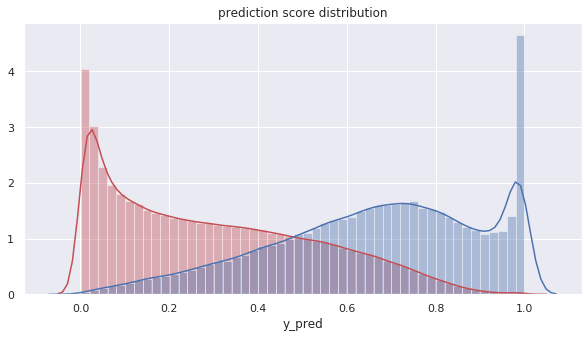

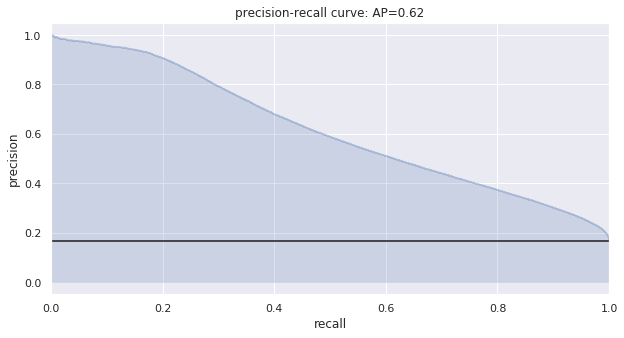

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/lgb_0708_170412.pkl
save model to  /home/dmig/work/upsell/result/lgb_0708_170412.pkl


In [97]:
lgb_result_dict = evaluate(x_val, y_val.label.values, clf, 'lgb')

### 1, 2, 3, 4 월 데이터

In [98]:
test_period_list = ['201901', '201902', '201903', '201904']

In [99]:
def test_different_period(clf, test_ym):
    print('test ym: ', test_ym)
    
    # load data
    print('load data')
    df_mart = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_{}.pkl'.format(test_ym)))
    print('df_mart: ', df_mart.shape)
    
    # make test data format
    print('make test data format')
    result = make_test_data(df_mart)
    idx = result['idx']
    x_test = result['x']
    y_test = result['y']
    feature_cols = list(x_test.columns)
    print('x_test: ', x_test.shape)
    print('y_test: ', y_test.shape)
    
    # evaluation
    print('evaluation')
    t1 = time.time()
    lgb_result_dict = evaluate(x_test, y_test.label.values, clf, 'lgb')
    print('elapsed time: ', time.time()-t1)

test ym:  201901
load data
df_mart:  (18176215, 81)
make test data format
x_test:  (18176215, 79)
y_test:  (18176215, 1)
evaluation
        acc    recall  precision  f1_score       auc
0  0.769468  0.760634   0.058565  0.108756  0.853966
         pred: 1   pred: 0
true: 1   255659     80454
true: 0  4109737  13730365
                       feature      description  importance
44     avg_subscription_period     평균 요금제 변경 주기       21565
6            last_equip_period              NaN       17509
5              svc_scrb_period              NaN       16461
1                          age               나이       13005
3              mng_nice_cb_scr        나이스 신용 점수       10032
53            data_usage_ratio              NaN        9866
9                  eqp_out_prc           단말 출고가        8809
54  bf_m6_data_usage_ratio_avg        데이터 소진 비율        8730
48             real_arpu_bf_m3          순수 ARPU        7713
49               real_avg_arpu          평균 ARPU        7671
46             real_a

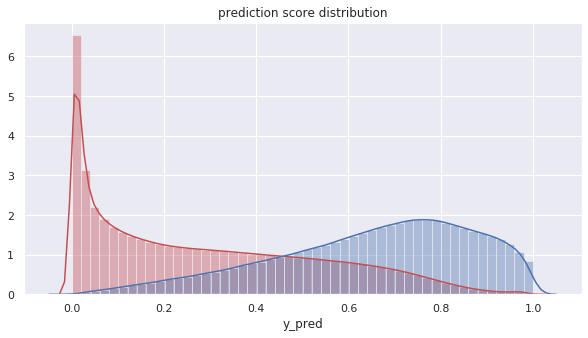

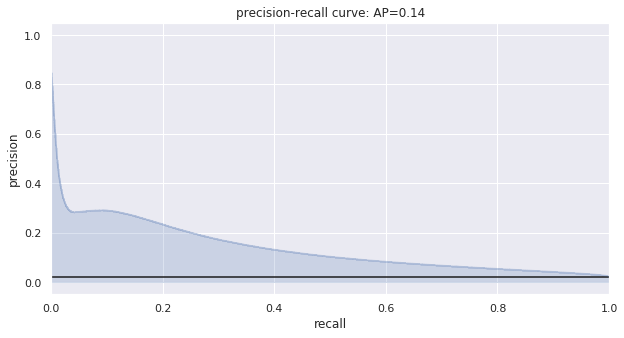

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/lgb_0708_171256.pkl
save model to  /home/dmig/work/upsell/result/lgb_0708_171256.pkl
elapsed time:  501.6539568901062
test ym:  201902
load data
df_mart:  (18462905, 81)
make test data format
x_test:  (18462905, 79)
y_test:  (18462905, 1)
evaluation
        acc    recall  precision  f1_score       auc
0  0.784106  0.727405   0.082691    0.1485  0.847644
         pred: 1   pred: 0
true: 1   347579    130255
true: 0  3855770  14129301
                       feature      description  importance
44     avg_subscription_period     평균 요금제 변경 주기       21565
6            last_equip_period              NaN       17509
5              svc_scrb_period              NaN       16461
1                          age               나이       13005
3              mng_nice_cb_scr        나이스 신용 점수       10032
53            data_usage_ratio              NaN        9866
9                  eqp_out_prc      

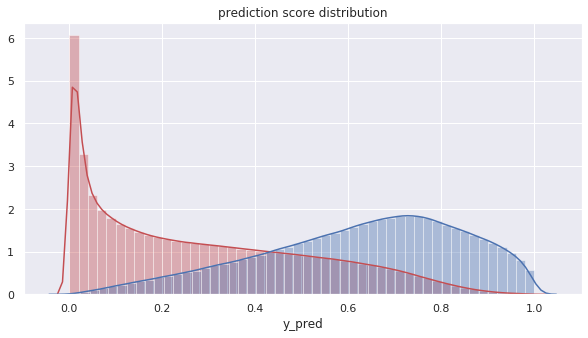

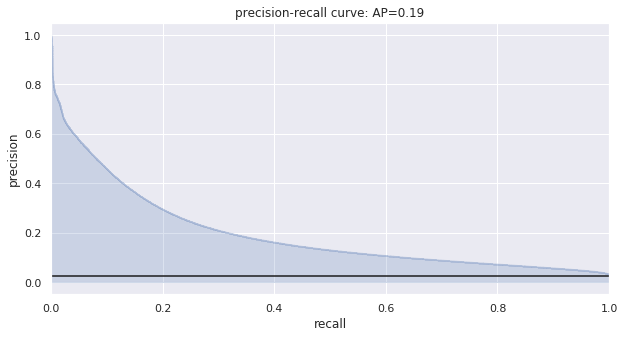

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/lgb_0708_172149.pkl
save model to  /home/dmig/work/upsell/result/lgb_0708_172149.pkl
elapsed time:  501.0214807987213
test ym:  201903
load data
df_mart:  (18580984, 81)
make test data format
x_test:  (18580984, 79)
y_test:  (18580984, 1)
evaluation
        acc    recall  precision  f1_score      auc
0  0.780098  0.759299   0.080862  0.146158  0.85578
         pred: 1   pred: 0
true: 1   349715    110861
true: 0  3975143  14145265
                       feature      description  importance
44     avg_subscription_period     평균 요금제 변경 주기       21565
6            last_equip_period              NaN       17509
5              svc_scrb_period              NaN       16461
1                          age               나이       13005
3              mng_nice_cb_scr        나이스 신용 점수       10032
53            data_usage_ratio              NaN        9866
9                  eqp_out_prc        

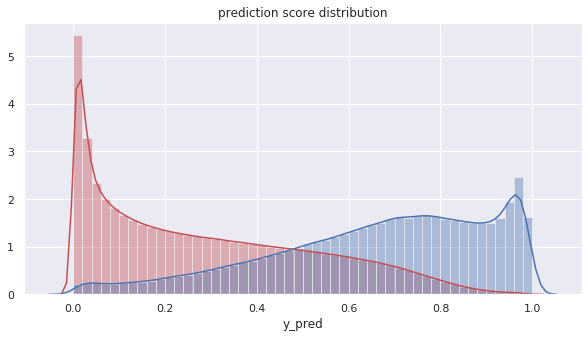

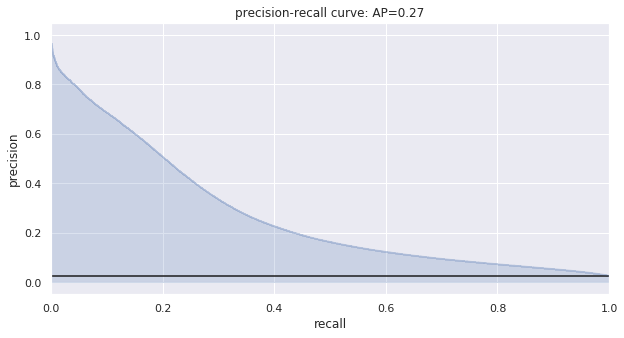

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/lgb_0708_173120.pkl
save model to  /home/dmig/work/upsell/result/lgb_0708_173120.pkl
elapsed time:  539.5281414985657
test ym:  201904
load data
df_mart:  (18626176, 81)
make test data format
x_test:  (18626176, 79)
y_test:  (18626176, 1)
evaluation
        acc    recall  precision  f1_score       auc
0  0.783561  0.749357   0.089147  0.159339  0.857386
         pred: 1   pred: 0
true: 1   382058    127790
true: 0  3903641  14212687
                       feature      description  importance
44     avg_subscription_period     평균 요금제 변경 주기       21565
6            last_equip_period              NaN       17509
5              svc_scrb_period              NaN       16461
1                          age               나이       13005
3              mng_nice_cb_scr        나이스 신용 점수       10032
53            data_usage_ratio              NaN        9866
9                  eqp_out_prc      

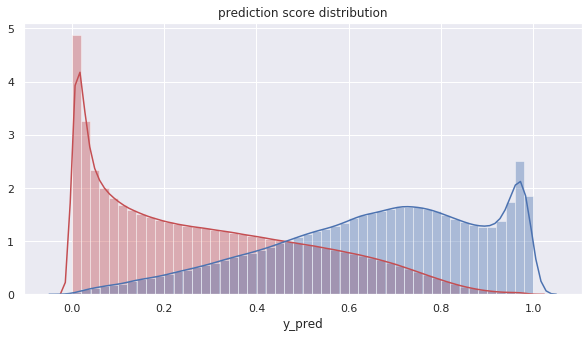

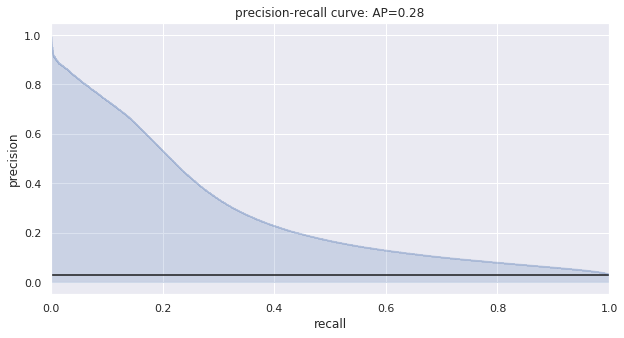

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/lgb_0708_174158.pkl
save model to  /home/dmig/work/upsell/result/lgb_0708_174158.pkl
elapsed time:  608.5564534664154


In [100]:
for p in test_period_list:
    test_different_period(clf, p)

## 결론
- 역시나 가까운 월일 때, 성능이 잘나옴
- 1,2,3,4월 training -> 5월 test 시 auprc가 0.05
- 5월 training -> 1,2,3,4월 test 시 auprc는 0.14, 0.19, 0.27, 0.28
- 1,2,3,4 월로 학습된 모델은 왜 5월 데이터 테스트시 성능이 안좋을까?
    - 학습 시 중요하게 여겨지는 feature가 5월에는 이상한 분포
    - 1,2,3,4월 input에 후행변수가 있음

## TODO
- 이유를 찾기
- 모델의 결과를 잘 이해할 수 있는 시각화, etc 모듈 만들기
    - 주요 feaure 분포(total, label별)
    - shap valus